In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve


import warnings
warnings.filterwarnings('ignore')

# Resource: https://www.justintodata.com/logistic-regression-example-in-python/


### Read and Explore the Data

In [2]:
# read the data

df = pd.read_csv('../data/heart_attack_data.csv')

# preview the data

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [3]:
# check the shape of the data

df.shape

# we have 294 rows of data, and 14 potential features.

(294, 14)

In [4]:
# check the summary information of the data
# do we have any categorical data that needs processing?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [5]:
# check the distribution of the target

df.target.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with only 12% of users having churned - will oversample the data

0    0.639456
1    0.360544
Name: target, dtype: float64

In [6]:
df.target.value_counts(normalize = True)

0    0.639456
1    0.360544
Name: target, dtype: float64

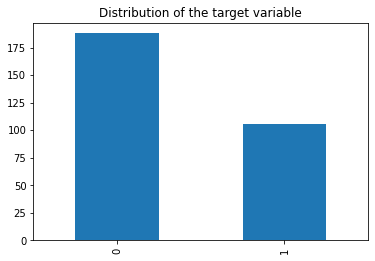

In [7]:
# visualise the distribution of the target

df.target.value_counts(dropna = True).plot(kind = 'bar')
plt.title("Distribution of the target variable");

# question: does the distribution look equal to you? 
# example of an imbalanced dataset

### Handle Missing Data

In [8]:
# identify missing values

def missing_dataframe(df):
    """
    @param df pandas DataFrame
    @return a DataFrame with the percentage of missing data for every feature
    """
    
    percent_missing = df.isnull().mean() 
    
    missing_value_df = pd.DataFrame(percent_missing).reset_index() # convert to DataFrame
    missing_value_df = missing_value_df.rename(columns = {"index" : "feature",
                                                                0 : "percent_missing"}) # rename columns

    missing_value_df = missing_value_df.sort_values(by = ['percent_missing'], ascending = False) # sort the values
    
    return missing_value_df

In [9]:
missing_value_df = missing_dataframe(df)
missing_value_df

,feature,percent_missing
11,ca,0.989796
12,thal,0.904762
10,slope,0.646259
4,chol,0.078231
5,fbs,0.027211
3,trestbps,0.003401
6,restecg,0.003401
7,thalach,0.003401
8,exang,0.003401
0,age,0.000000


In [10]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 0.4

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 3
['ca', 'thal', 'slope']


In [11]:
df.drop(cols_to_drop, axis = 1, inplace = True)

In [12]:
# check the columns were dropped

missing_value_df = missing_dataframe(df)
missing_value_df

,feature,percent_missing
4,chol,0.078231
5,fbs,0.027211
3,trestbps,0.003401
6,restecg,0.003401
7,thalach,0.003401
8,exang,0.003401
0,age,0.000000
1,sex,0.000000
2,cp,0.000000
9,oldpeak,0.000000


In [13]:
# fill the remaining features with missing values with 0

df.chol.fillna(0, inplace = True)
df.fbs.fillna(0, inplace = True)
df.trestbps.fillna(0, inplace = True)
df.restecg.fillna(0, inplace = True)
df.exang.fillna(0, inplace = True)
df.thalach.fillna(0, inplace = True)


In [14]:
# check to see if we have any missing values that need handling

missing_value_df = missing_dataframe(df)
missing_value_df

,feature,percent_missing
0,age,0.0
1,sex,0.0
2,cp,0.0
3,trestbps,0.0
4,chol,0.0
5,fbs,0.0
6,restecg,0.0
7,thalach,0.0
8,exang,0.0
9,oldpeak,0.0


In [15]:
df.shape

(294, 11)

### Split the data into train and test

In [16]:
# define the target and features

target = df["target"]
features = df.drop(["target"], axis = 1)


In [17]:
target.shape

(294,)

In [18]:
features.shape

(294, 10)

In [19]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.2, 
                                                random_state = 8888)



In [20]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Distribution of target:", Counter(y_train))

Training Data
Shape of X_train (235, 10)
Shape of y_train (235,)
Distribution of target: Counter({0: 148, 1: 87})


In [21]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Distribution of target:", Counter(y_test))

Test Data
Shape of X_test (59, 10)
Shape of y_test (59,)
Distribution of target: Counter({0: 40, 1: 19})


### Scale the training data

In [22]:
# Scale the data (only X_train)

scaler = StandardScaler()
scaler.fit(X_train)

# transform training data
X_train_scaled = scaler.transform(X_train)


In [23]:
X_train_scaled

array([[ 0.66180977,  0.5920935 , -0.01783973, ..., -0.34625778,
        -0.6846532 , -0.65446919],
       [-0.63423436,  0.5920935 ,  1.03024439, ..., -0.34625778,
         1.46059349,  1.49208013],
       [-0.89344319,  0.5920935 , -1.06592385, ...,  0.86822846,
        -0.6846532 , -0.65446919],
       ...,
       [ 1.05062301,  0.5920935 , -0.01783973, ..., -0.42722353,
         1.46059349,  0.41880547],
       [-0.37502554, -1.68892244, -1.06592385, ...,  1.67788594,
        -0.6846532 , -0.65446919],
       [-1.15265202,  0.5920935 ,  1.03024439, ...,  0.46339971,
        -0.6846532 , -0.65446919]])

In [24]:
# print the shape of the scaled training data

print("Training Data")
print("Shape of X_train_scaled:", X_train_scaled.shape)


Training Data
Shape of X_train_scaled: (235, 10)


In [25]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak
265,53,1,3,145.0,518.0,0.0,0.0,130.0,0.0,0.0
200,43,1,4,150.0,247.0,0.0,0.0,130.0,1.0,2.0
48,41,1,2,120.0,291.0,0.0,1.0,160.0,0.0,0.0
16,36,1,2,120.0,166.0,0.0,0.0,180.0,0.0,0.0
132,53,0,2,140.0,216.0,0.0,0.0,142.0,1.0,2.0


### Build the Logistic Regression Model - using scaled data

In [26]:
# Import and Fit the logistic regression model

clf = LogisticRegression()
# logistic regression with no penalty term in the cost function.

clf.fit(X_train_scaled, y_train)

LogisticRegression()

### Evaluate the Logistic Regression Model on unseen data

In [27]:
# Make predictions on unseen data

y_pred = clf.predict(X_test) 
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
print("first five predicted values:", y_pred[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [1 0 1 1 1]
first five actual values: [0, 1, 0, 0, 0]


In [29]:
# accuracy
# Very simply, accuracy is the fraction of predictions our model got right. 

accuracy_score(y_test, y_pred)


0.423728813559322

In [30]:
# recall
# What proportion of actual positives (1) was identified correctly?
# tp / tp + fn

recall_score(y_test, y_pred)


0.9473684210526315

In [31]:
# precision
# What proportion of positive identifications (1) was actually correct?
# tp / tp + fp

precision_score(y_test, y_pred)

0.35294117647058826

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.17      0.29        40
           1       0.35      0.95      0.51        19

    accuracy                           0.42        59
   macro avg       0.61      0.56      0.40        59
weighted avg       0.71      0.42      0.36        59



In [33]:
# f1 score
# balance between precision and recall

f1_score(y_test, y_pred)

0.5142857142857143

In [34]:
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

confusion_matrix(y_test, y_pred)

array([[ 7, 33],
       [ 1, 18]])

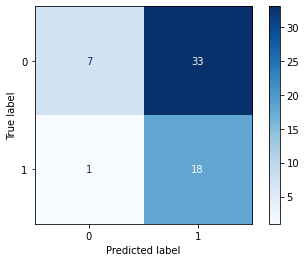

In [35]:
# can easily see where the model has incorrectly classified the data

plot_confusion_matrix(clf, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

In [36]:
# calculation based on confusion matrix
# look at the diagonal, with the tp and tn , this is when the model predicted correctly

accuracy = (7 + 18)/(7 + 33 + 1 + 18)
accuracy

0.423728813559322

In [37]:
# What proportion of actual positives (1) was identified correctly?
# tp / tp + fn

recall = (18) / (18 + 1)
recall

0.9473684210526315

In [38]:
# precision
# What proportion of positive identifications (1) was actually correct?
# tp / tp + fp

precision = 18 / (18 + 33)
precision

0.35294117647058826

In [39]:
# f1 - score
# F1 = 2 * (precision * recall) / (precision + recall)

f1 = 2 * (precision * recall / (precision + recall))
f1

0.5142857142857143

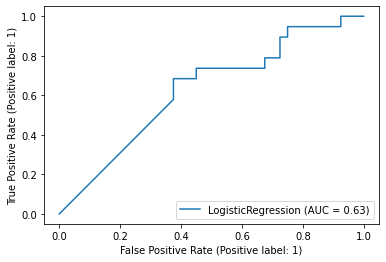

In [40]:
# handy sklearn function to plot Receiver operating characteristic (ROC) curve, with the area under the curve.
# The TPR (recall) defines how many correct positive results occur among all positive samples available during the test. 
# FPR, on the other hand, defines how many incorrect positive results occur among all negative samples 
# available during the test.

plot_roc_curve(clf,
               X_test, 
               y_test);                      

# AUC of 0.63; the higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

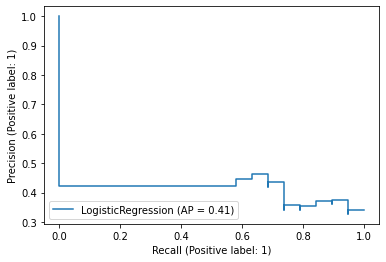

In [41]:
# Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
# In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
# The precision-recall curve shows the tradeoff between precision and recall for different threshold. 

plot_precision_recall_curve(clf,
                            X_test,
                            y_test);

# Balance between precision and recall could be higher

## Task: Can you build and evaluate a Decision Tree Classifier?

In [42]:
# Import the Decision Tree Classifier

clf_tree = DecisionTreeClassifier()

In [43]:
# fit the decision tree classifier

clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

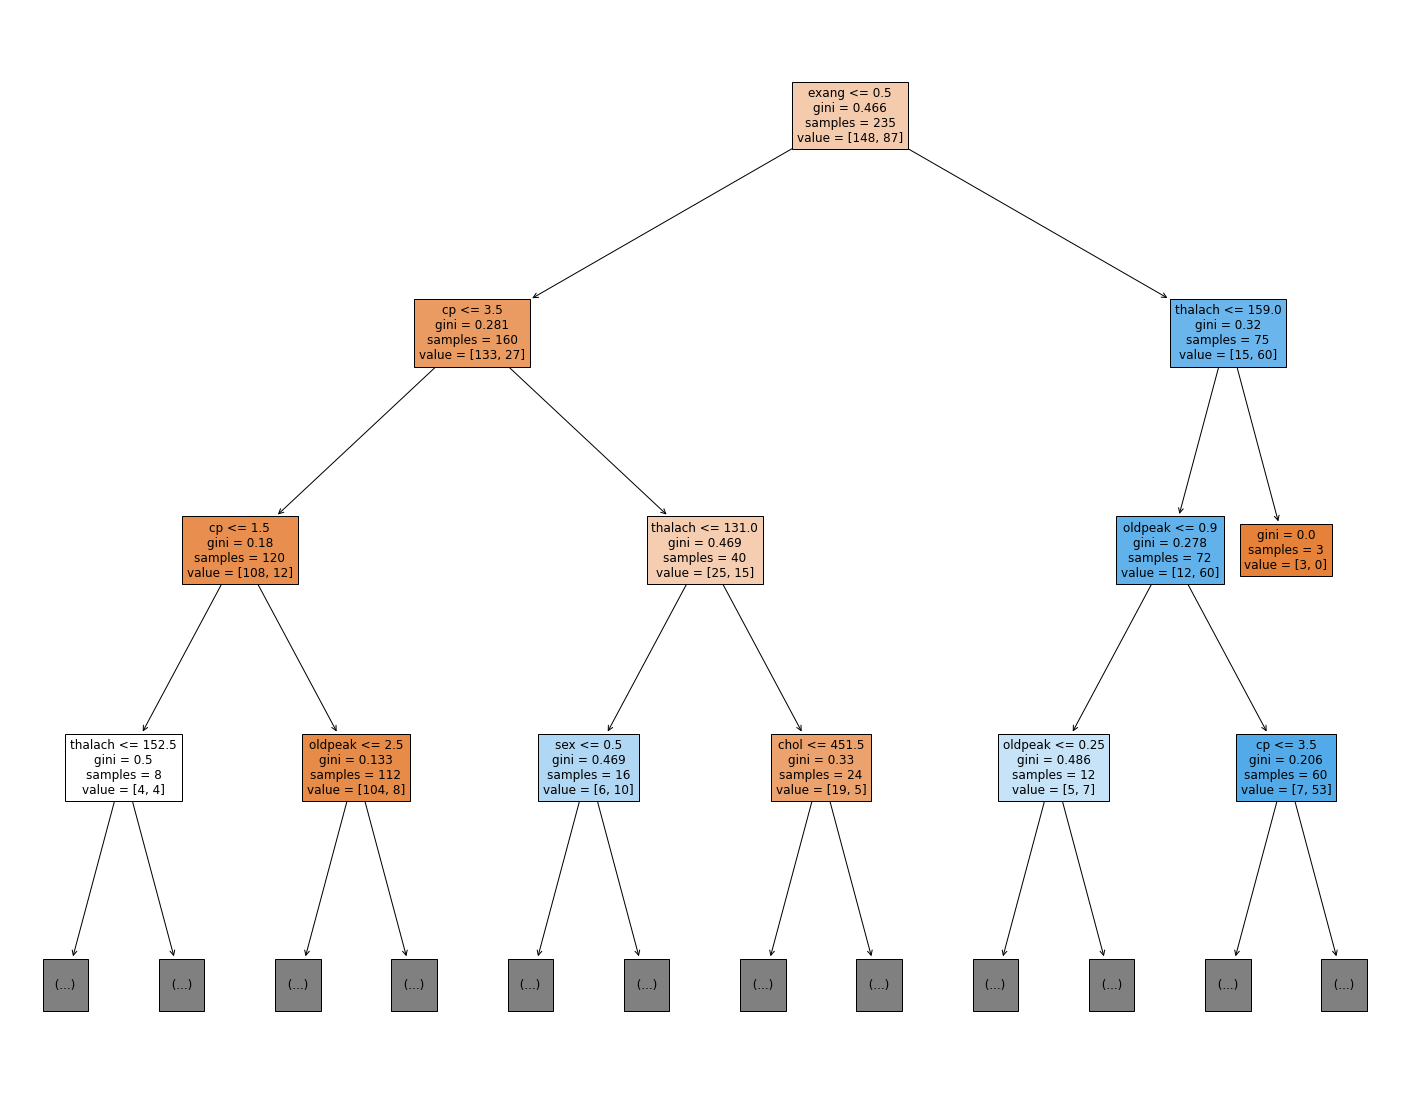

In [44]:
# visualising the decision tree

from sklearn import tree

fig = plt.figure(figsize=(25 , 20))
_ = tree.plot_tree(clf_tree, 
                   feature_names = list(X_train.columns),  
                   max_depth = 3,
                   filled = True)

In [45]:
# make predictions

y_pred = clf_tree.predict(X_test)
print(Counter(y_pred))

Counter({0: 41, 1: 18})


In [46]:
print("first five predicted values:", y_pred[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [0 0 0 1 0]
first five actual values: [0, 1, 0, 0, 0]


In [47]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("recall:", round(recall_score(y_test, y_pred), 2))
print("precision:", round(precision_score(y_test, y_pred), 2))
print("f1-score:", round(f1_score(y_test, y_pred), 2))

# higher accuracy than the logistic regression model, but lower recall - compare the f1-score

accuracy: 0.64
recall: 0.42
precision: 0.44
f1-score: 0.43


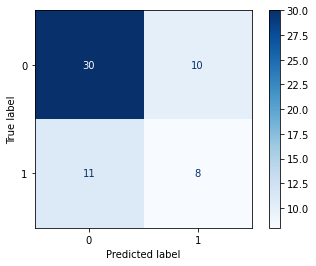

In [48]:
plot_confusion_matrix(clf_tree, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues)

plt.show();

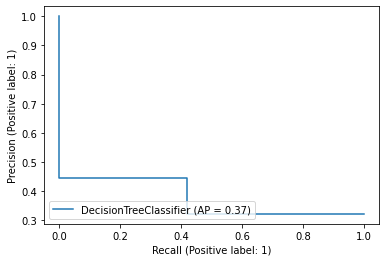

In [49]:
plot_precision_recall_curve(clf_tree,
                            X_test,
                            y_test);

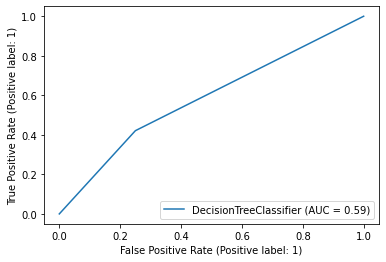

In [51]:
plot_roc_curve(clf_tree,
               X_test, 
               y_test);

## Task: Can you build and evaluate a Random Forest Classifier?

In [52]:
# Import the Random Forest Classifier

rf = RandomForestClassifier()

In [53]:
# fit the Random Forest classifier

rf.fit(X_train, y_train)

RandomForestClassifier()

In [54]:
# make predictions

y_pred = rf.predict(X_test)
print(Counter(y_pred))

Counter({0: 44, 1: 15})


In [55]:
print("first five predicted values:", y_pred[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [0 1 0 1 0]
first five actual values: [0, 1, 0, 0, 0]


In [56]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("recall:", round(recall_score(y_test, y_pred), 2))
print("precision:", round(precision_score(y_test, y_pred), 2))
print("f1-score:", round(f1_score(y_test, y_pred), 2))

# has the highest accuracy so far, and the recall, precision and f1-score is higher than the decision tree classifier

accuracy: 0.8
recall: 0.58
precision: 0.73
f1-score: 0.65


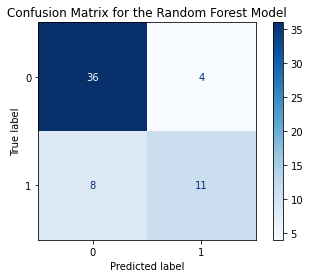

In [57]:
plot_confusion_matrix(rf, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues)

plt.title("Confusion Matrix for the Random Forest Model");

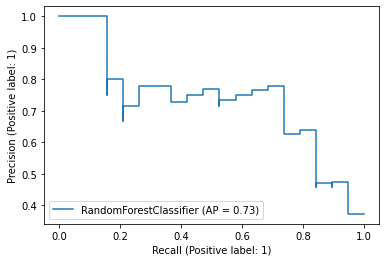

In [58]:
plot_precision_recall_curve(rf,
                            X_test,
                            y_test);

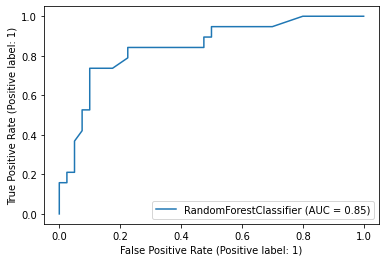

In [59]:
plot_roc_curve(rf,
               X_test, 
               y_test);

# AUC close to 1, so far this is the best performing model

### Can we improve the model? 

In [60]:
# Question: How can we improve the performance of the model? What would we improve? 
# I would like to the model to predict more 1s for e.g.

# 1. Oversampling the data

# from imblearn.over_sampling import SMOTE

# define oversampling strategy
# SMOTE = SMOTE()

# fit and apply the transform
# X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)
# X_train_SMOTE = pd.DataFrame(X_train_SMOTE, columns = X_train.columns) # to keep dataframe structure

# summarize class distribution
# print("After oversampling: ", Counter(y_train_SMOTE))

In [61]:
# 2. HYPERPARAMETER TUNING
# RESOURCE: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

In [62]:

rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [63]:
y_pred = rf.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [64]:
print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("recall:", round(recall_score(y_test, y_pred), 2))
print("precision:", round(precision_score(y_test, y_pred), 2))
print("f1-score:", round(f1_score(y_test, y_pred), 2))

# do we see an improvement in accuracy?

accuracy: 0.8
recall: 0.58
precision: 0.73
f1-score: 0.65
